In [24]:
import numpy as np
import pandas as pd
import csv
import copy
from pprint import pprint
from math import *
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing

In [25]:
dataset = pd.read_csv('Train_E.csv')
#handling missing values...
dataset = dataset.fillna(dataset.mean())

#kicking date...
dataset = dataset.drop(['date'], axis = 1)

#one hot encoding for categorical columns (iso_code, continent, location)...
dummy_iso_code = pd.get_dummies(dataset['iso_code'], prefix = "iso_code")
dummy_continent = pd.get_dummies(dataset['continent'], prefix = "continent")
dummy_location = pd.get_dummies(dataset['location'], prefix = "location")
dataset = pd.concat([dummy_location, dataset], axis = 1)
dataset = pd.concat([dummy_continent, dataset], axis = 1)
dataset = pd.concat([dummy_iso_code, dataset], axis = 1)
dataset = dataset.drop(['iso_code', 'continent', 'location'], axis = 1)

#normalizing data...
x = dataset.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pd.DataFrame()
dataset = pd.DataFrame(data = x_scaled, columns = dataset.columns)
dataset.head()

,iso_code_ABW,iso_code_AFG,iso_code_AGO,iso_code_ALB,iso_code_ARE,continent_Africa,continent_Asia,continent_Europe,continent_North America,location_Afghanistan,location_Albania,location_Angola,location_Aruba,location_United Arab Emirates,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,life_expectancy
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00002,0.001625,0.126530,0.000000,0.000000,0.079661,0.000490,0.011364,0.054990,0.000000,0.000000,0.045381,0.000000,0.0,1.0,1.0,0.991448,0.853271,0.52176,0.576577,0.869116
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.12764,0.114698,0.000262,0.138444,0.038946,0.000000,0.063975,0.028611,0.003169,0.090876,0.015617,0.000000,0.367313,0.0,1.0,1.0,0.991448,0.853271,0.52176,0.576577,0.869116
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00004,0.001625,0.000262,0.000000,0.000000,0.000000,0.000981,0.011364,0.003169,0.000000,0.000000,0.000000,0.367313,0.0,1.0,1.0,0.991448,0.853271,0.52176,0.576577,0.869116
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.12764,0.114698,0.000262,0.138444,0.038946,0.000000,0.063975,0.028611,0.003169,0.090876,0.015617,0.000000,0.489751,0.0,1.0,1.0,0.991448,0.853271,0.52176,0.576577,0.869116
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.12764,0.114698,0.000262,0.138444,0.038946,0.000000,0.063975,0.028611,0.003169,0.090876,0.015617,0.000000,0.489751,0.0,1.0,1.0,0.991448,0.853271,0.52176,0.576577,0.869116


In [26]:
def train_test_split(s_dataset):
    k=int(len(s_dataset.index)*0.8)
    training_data = s_dataset.iloc[:k].reset_index(drop=True)
    testing_data = s_dataset.iloc[k:].reset_index(drop=True)
    return training_data,testing_data

In [27]:
#random shuffle
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
training_data,testing_data = train_test_split(dataset)
#training_data.head()

In [28]:
def k_fold_validation(training_data,k):
    train_list = list()
    validation_list = list()
    l = len(training_data.index)
    fold = int(l/k)
    for i in range(k):
      validation_list.append(training_data.iloc[i*fold:(i+1)*int(l/k)].reset_index(drop = True))
      train_copy = copy.deepcopy(training_data)
      train_list.append(train_copy.drop(train_copy.index[i*fold:(i+1)*int(l/k)]).reset_index(drop = True))
    return train_list,validation_list

In [29]:
train_list,validation_list=k_fold_validation(training_data,5)
#print(train_list)
#print('allo allo')
#print(validation_list)

In [30]:
def summary_util(train_data):
    result = list()
    attributes = train_data.columns
    for attribute in attributes:
      if (attribute != 'life_expectancy'):
        result.append([train_data[attribute].mean(), train_data[attribute].std()])
    return result

def summary(train_data):
    l = len(train_data.index)
    result = {}
    classes = train_data['life_expectancy'].unique()
    freq = train_data['life_expectancy'].value_counts()
    prior_probs = {}
    for label in classes:
        prior_probs[label] = freq[label]/l;
        result[label] = summary_util(train_data[train_data['life_expectancy'] == label])
    return result,prior_probs

def gaussian(x, mean, stdev):
    if stdev == 0:
      return float(x == mean)
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent  

In [31]:
def probability(row,summ_by_class):
  prob = 1
  i = 0
  for item in row.index:
    if(item != 'life_expectancy'):
      prob *= gaussian(row[item],summ_by_class[i][0],summ_by_class[i][1])
      i += 1      
  return prob

In [32]:
def test(train_data,test_data):
  sep_class,prior_probs=summary(train_data)
  predicted_class=[]
  for i,row in test_data.iterrows():
    prob_by_class={}   
    #print(row)
    for item in sep_class:      
      prob_by_class[item]=probability(row,sep_class[item])*prior_probs[item]
    predicted_class.append(max(prob_by_class, key=prob_by_class.get))
  return predicted_class

In [33]:
def accuracy(train_data,test_data):
  predicted_classes = test(train_data,test_data)
  correct = 0
  for i in range(len(predicted_classes)):
    if predicted_classes[i] == test_data['life_expectancy'][i]:
      correct += 1
  return 100*correct/len(predicted_classes)

In [34]:
for i in range(5):
  print('validation-accuracy for set'+ str(i+1)+': '+str(accuracy(train_list[i],validation_list[i])))
print('test-accuracy: '+str(accuracy(training_data,testing_data)))

validation-accuracy for set1: 100.0
validation-accuracy for set2: 100.0
validation-accuracy for set3: 100.0
validation-accuracy for set4: 100.0
validation-accuracy for set5: 100.0
test-accuracy: 100.0


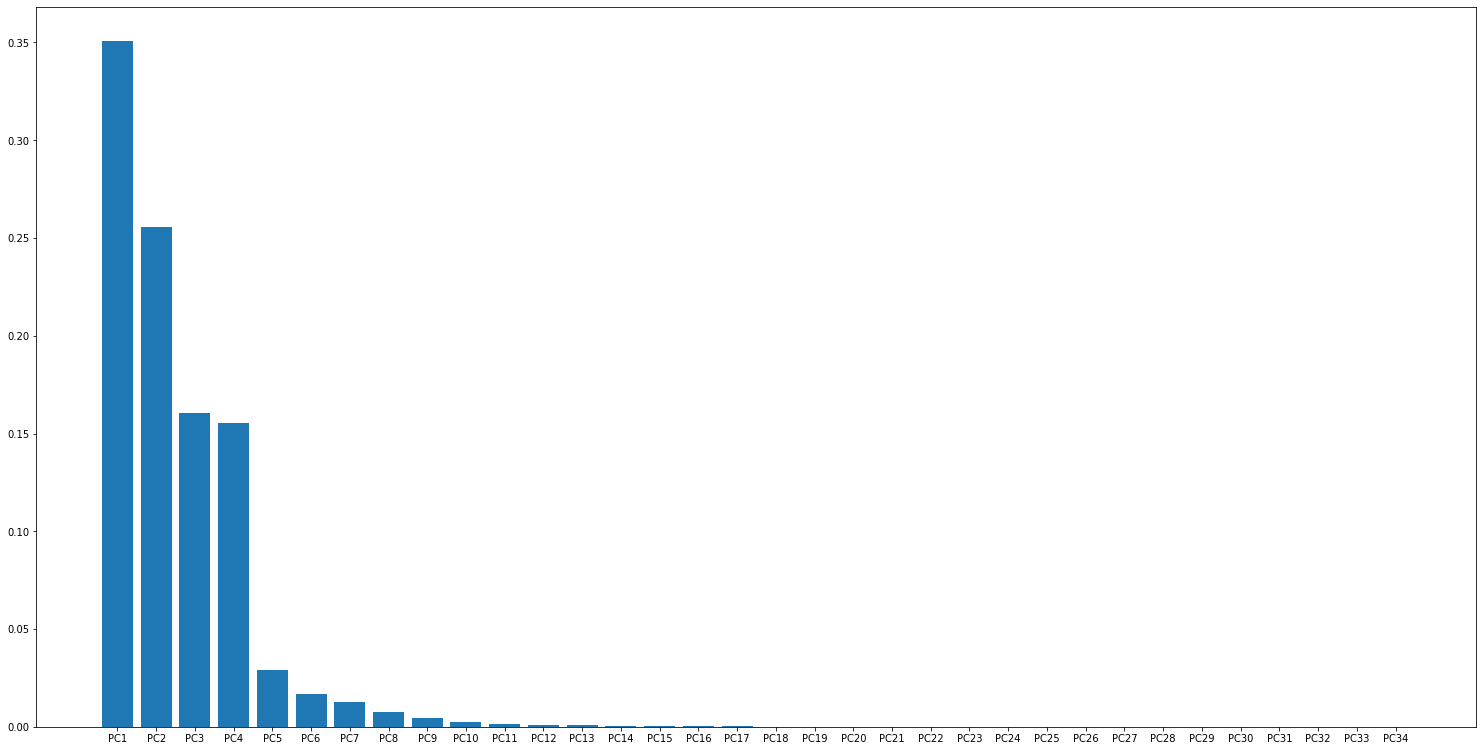

The number of components to be used is 5


In [35]:
#pca stuff...
dataset_X = copy.deepcopy(dataset)
dataset_X = dataset_X.drop(['life_expectancy'], axis = 1)
dataset_Y = copy.deepcopy(dataset)
dataset_Y = dataset_Y['life_expectancy']

pc_columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34']

pca = decomposition.PCA()
pc = pca.fit_transform(dataset_X)

pc_df = pd.DataFrame(data = pc, columns = pc_columns)
pc_df['life_expectancy'] = dataset_Y
#pc_df.head()

#print(pca.explained_variance_ratio_)

fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(pc_columns, pca.explained_variance_ratio_)
plt.show()

i = 0
var = 0
while (var<0.95):
  var += pca.explained_variance_ratio_[i]
  i += 1
print("The number of components to be used is " + str(i))



In [36]:
pc_df = pc_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'life_expectancy']]
#pc_df.head()
pc_df = pc_df.sample(frac = 1, random_state = 0).reset_index(drop = True)
pc_training_data,pc_testing_data = train_test_split(pc_df)
pc_train_list,pc_validation_list=k_fold_validation(pc_training_data,5)
for i in range(5):
  print('pc_validation-accuracy for set'+ str(i+1)+': '+str(accuracy(pc_train_list[i],pc_validation_list[i])))
print('pc_test-accuracy: '+str(accuracy(pc_training_data,pc_testing_data)))

pc_validation-accuracy for set1: 100.0
pc_validation-accuracy for set2: 100.0
pc_validation-accuracy for set3: 100.0
pc_validation-accuracy for set4: 100.0
pc_validation-accuracy for set5: 100.0
pc_test-accuracy: 100.0
